![Machine Learning for Scientists in a hurry](./fig/Title_ML.png)

# Boilerplate

In [1]:
from IPython.display import Math, HTML, display

def set_css_in_cell_output():
  display(HTML("""<style>
    .div-1 {
        background-color: #EBEBEB;
    }

    .div-2 {
    	background-color: #ABBAEA;
    }

    .div-3 {
    	background-color: #FBD603;
    }
    .div-white {
    	background-color: #FBFBFB;
    }
    h1 {
      color: #002855;
    }
    h2 {
      color: #002855;
    }
</style>
"""))

get_ipython().events.register('pre_run_cell', set_css_in_cell_output)


In [2]:
!pip install watermark

In [3]:
!if [ ! -f helpers.py ]; then wget "https://raw.githubusercontent.com/romerogroup/Notebooks_4SIAH/main/Machine_Learning/helpers.py"; fi

<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 60%; padding: 5px">
  <h1 id="subtitle">Chapter 4. Regression Analysis</h1>
  <h2 id="subtitle">Guillermo Avendaño Franco<br>Aldo Humberto Romero</h2>
  <br>
  <img src="fig/1-line logotype124-295.png" alt="Scientific Computing with Python" style="width:50%" align="left">
  </div>
  <div style="border: none; float: left; width: 30%; padding: 5px">
  <img src="fig/SCPython.png" alt="Scientific Computing with Python" style="width:100%">
  </div>
</div>

## Setup

In [4]:
%load_ext watermark

In [5]:
%watermark

Last updated: 2023-10-22T17:41:33.034508-04:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.14.0

Compiler    : Clang 11.0.3 (clang-1103.0.32.62)
OS          : Darwin
Release     : 19.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [6]:
import time
start = time.time()
chapter_number = 4
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import sklearn

In [8]:
%watermark -iv

sklearn   : 1.3.0
numpy     : 1.25.2
matplotlib: 3.8.0



# Where we are on the map?

<img src="fig/ml_map.png" width="700" height="200" title="Precision vs Recall" alt="Precision vs Recall"></a>

# Regression Analysis

In statistical modeling, **regression analysis** is a set of statistical processes for estimating the relationships among variables. It includes many techniques for modeling and analyzing several variables when the focus is on the relationship between a dependent variable and one or more independent variables (or 'predictors'). More specifically, regression analysis helps one understand how the typical value of the dependent variable (or 'criterion variable') changes when any one of the independent variables is varied, while the other independent variables are held fixed. 

In a narrower sense, regression may refer specifically to the estimation of continuous response (dependent) variables, as opposed to the discrete response variables used in **classification**. The case of a continuous dependent variable may be more specifically referred to as metric regression to distinguish it from related problems.

# Linear regression using the Normal Equation

`LinearRegression` fits a linear model with coefficients $w = (w_1, \cdots, w_p)$ to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation. Mathematically it solves a problem of the form:

\begin{equation}
\min_{w} || X w - y||_2^2
\end{equation}


In [9]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

(0.0, 2.0, 0.0, 15.0)

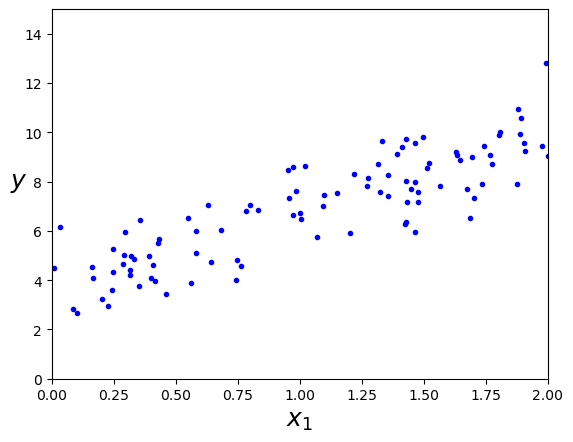

In [10]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])

In [11]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [12]:
theta_best

array([[3.66908777],
       [3.11594318]])

In [13]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[3.66908777],
       [9.90097413]])

(0.0, 2.0, 0.0, 15.0)

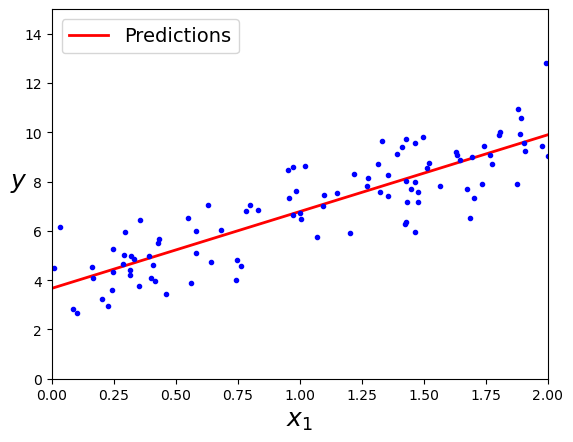

In [14]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])

In [15]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.66908777]), array([[3.11594318]]))

In [16]:
lin_reg.predict(X_new)

array([[3.66908777],
       [9.90097413]])

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for "least squares"), which you could call directly:

In [17]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.66908777],
       [3.11594318]])

This function computes $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the _pseudoinverse_ of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [18]:
np.linalg.pinv(X_b).dot(y)

array([[3.66908777],
       [3.11594318]])

# Linear regression using batch gradient descent

There is a close function to compute the  $\theta$ that minimizes the cost function

\begin{equation}
|| X \theta - y||_2^2
\end{equation}

where $||.||$ denotes the usual Euclidean vector norm.
The normal function:


\begin{equation}
  \hat{\boldsymbol\theta} = (\mathbf{X}^\mathsf{T}\mathbf{X})^{-1} \mathbf{X}^\mathsf{T} \mathbf{y},
\end{equation}

The problem with this kind of closed-form solution is that it is not well suited for large dimensions. The computational complexity scales as $O(n^3)$ (a bit better in some implementations) making this solution unfeasible for a large number of features. The good side is that the scaling with the number of training instances is linear

Gradient Descent is a usual algorithm for local minimization. The idea is to follow the steepest slope to reach a point of minima (actually an inflexion point).

The critical point is how to evaluate the gradient, for doing that a local inspection.

In [19]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [20]:
theta

array([[3.66908777],
       [3.11594318]])

In [21]:
X_new_b.dot(theta)

array([[3.66908777],
       [9.90097413]])

## Learning rates 

The learning rate is managed by the $\eta$ hyperparameter

In [22]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

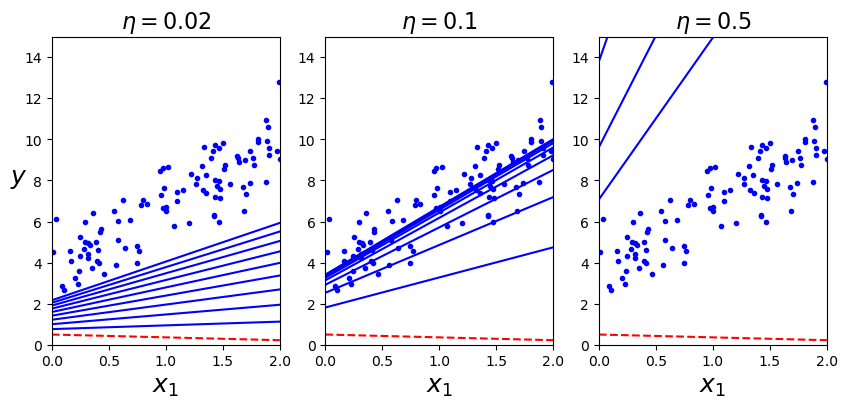

In [23]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

# Stochastic Gradient Descent

Instead of using the whole training set SGD uses a random subset on each iteration, effectively speeding the execution with the price of instability and bouncing of solutions

In [24]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

(0.0, 2.0, 0.0, 15.0)

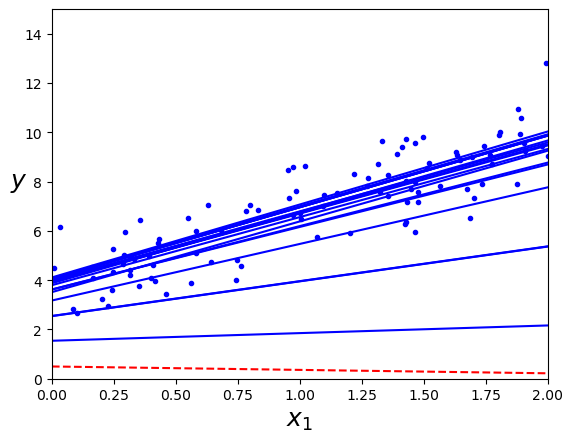

In [25]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # not shown
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # not shown

plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown

In [26]:
theta

array([[3.69531897],
       [3.14426174]])

In [27]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [28]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.63086509]), array([3.12732548]))

# Mini-batch gradient descent

In [29]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [30]:
theta

array([[3.61043415],
       [3.03047503]])

In [31]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

(2.5, 4.5, 2.3, 3.9)

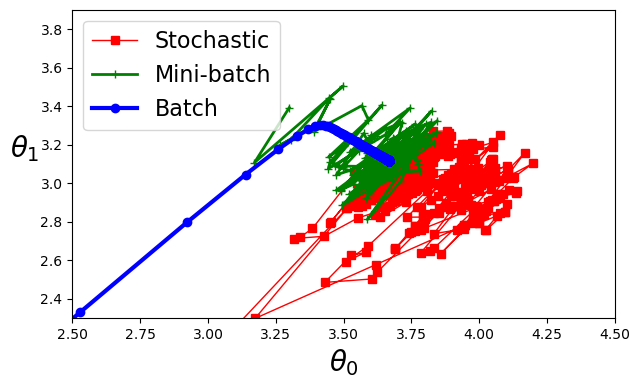

In [32]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])

# Polynomial regression

Polynomial regression is a trick to use the same machinery for linear regression but accounting for higher order polynomials for the features. The idea is to add more features that are powers of the original features and train a linear regressor as having those extra features.  

In [33]:
import numpy.random as rnd

np.random.seed(42)

In [34]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

(-3.0, 3.0, 0.0, 10.0)

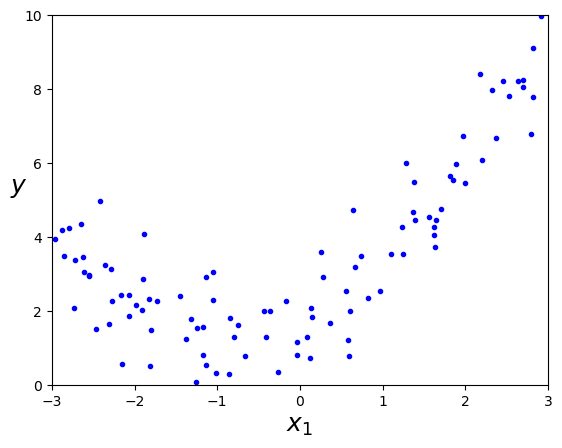

In [35]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])

In [36]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [37]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [38]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

(-3.0, 3.0, 0.0, 10.0)

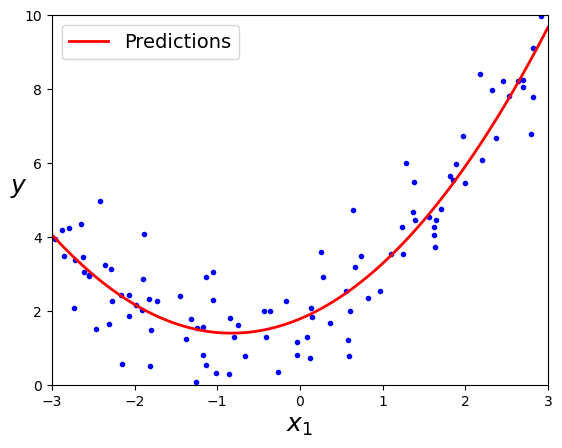

In [39]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])

## How high the polynomial should go?

(-3.0, 3.0, 0.0, 10.0)

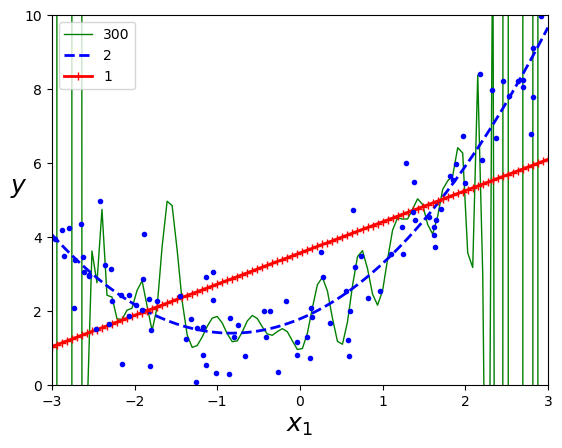

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])

# Regularized models

The figure above for 300-degree polynomial shows a big overfitting, which means
**try to keep the parameters** $\theta$ **small unless the data really convinces us otherwise**
. There are ways to control such behavior by constraining the weights of those high order polynomial penalizing solutions that use them. Therefore, the main idea is to add a penalty term to the algorithm’s loss function. This changes the model’s weights which results from minimizing the loss function.

## Ridge Regression

W very simple explanation of this regression type can be round in [Ridge Regression](https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Ridge_Regression.pdf). Basically, minimization problem of finding the parameters in the regression is converted to 

\begin{equation}
|| X \theta - y||_2^2 + \gamma || \theta ||_2^2
\end{equation}

where $\gamma \ge0$ is the so-called regularization parameter and it has to be chosen by the user. In general, the optimal value of $\gamma$ can be obtained by tuning or by cross-validation.

Now, the normal function now becomes:

\begin{equation}
  \hat{\boldsymbol\theta} = (\mathbf{X}^\mathsf{T}\mathbf{X} + \gamma I_{p+1})^{-1} \mathbf{X}^\mathsf{T} \mathbf{y},
\end{equation}

where $I_{p+1}$ is the identity matrix of $(p+1)\times(p+1)$.


In [41]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [42]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [43]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55072189]])

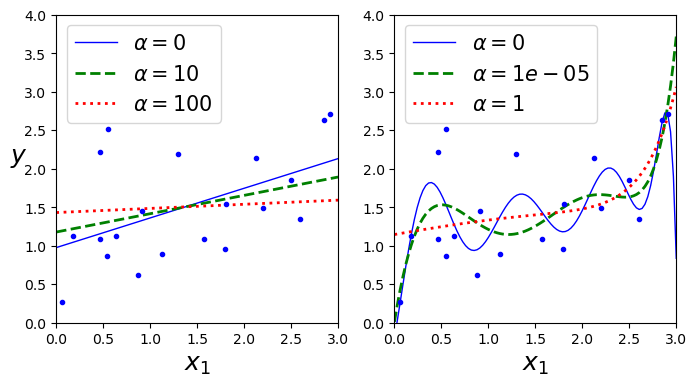

In [44]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

**Note**: to be future-proof, we set `max_iter=1000` and `tol=1e-3` because these will be the default values in Scikit-Learn 0.21.

In scikit-learn, this Regularization can be achieved with the `penalty="l2"` on the regressor. 

In [45]:
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

## Lasso Regression

The acronym “LASSO” stands for Least Absolute Shrinkage and Selection Operator and the minimization procedure happens on
\begin{equation}
|| X \theta - y||_2^2 + \gamma || \theta ||_1
\end{equation}

where $||.||_1$ is the so-called Manhattan norm. Compare with the Ride regression, there is no closed form for the parameters but it is still a problem that can be solved by using numerical optimization. LASSO tends to favor so-called sparse solutions where only a few of the parameters are non-zero, and the rest are exactly zero.

/Users/guilleaf/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.803e+00, tolerance: 9.295e-04
  model = cd_fast.enet_coordinate_descent(


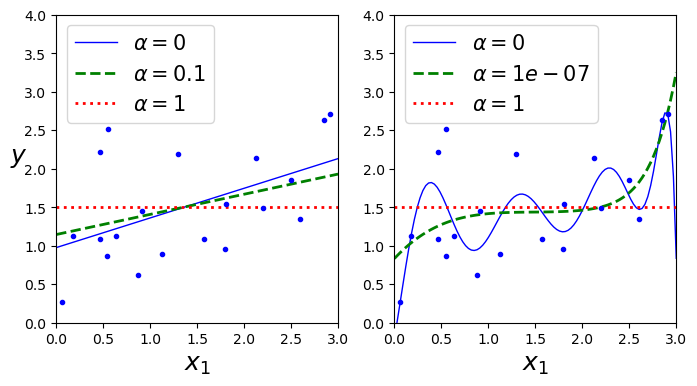

In [46]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

In [47]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

## Elastic Net

This one is a mix between Ridge and Lasso, where the minimization is now over

\begin{equation}
|| X \theta - y||_2^2 + \frac{1-r}{2} \gamma || \theta ||_1 + r \gamma || \theta ||_2^2
\end{equation}



In [48]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

In [49]:
from sklearn.model_selection import train_test_split
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

## Early stopping

Here the idea is to stop training as soon the validation error reaches a minimum

In [50]:
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=7, tol=1E4, warm_start=True, 
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

Create the graph:

Text(0, 0.5, 'RMSE')

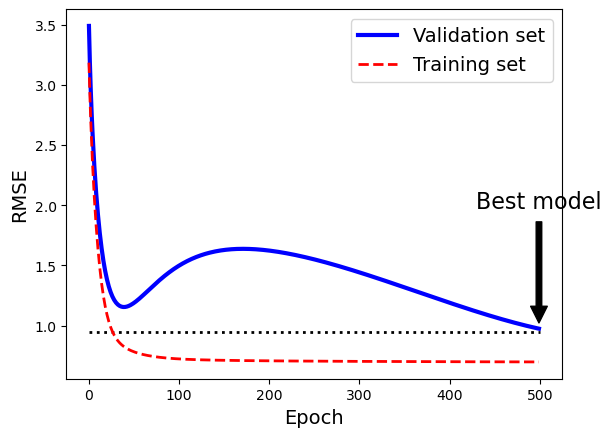

In [51]:
sgd_reg = SGDRegressor(max_iter=7, tol=1E4, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)

In [52]:
best_epoch, best_model

(499,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=7, penalty=None,
              random_state=42, tol=10000.0, warm_start=True))

In [53]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

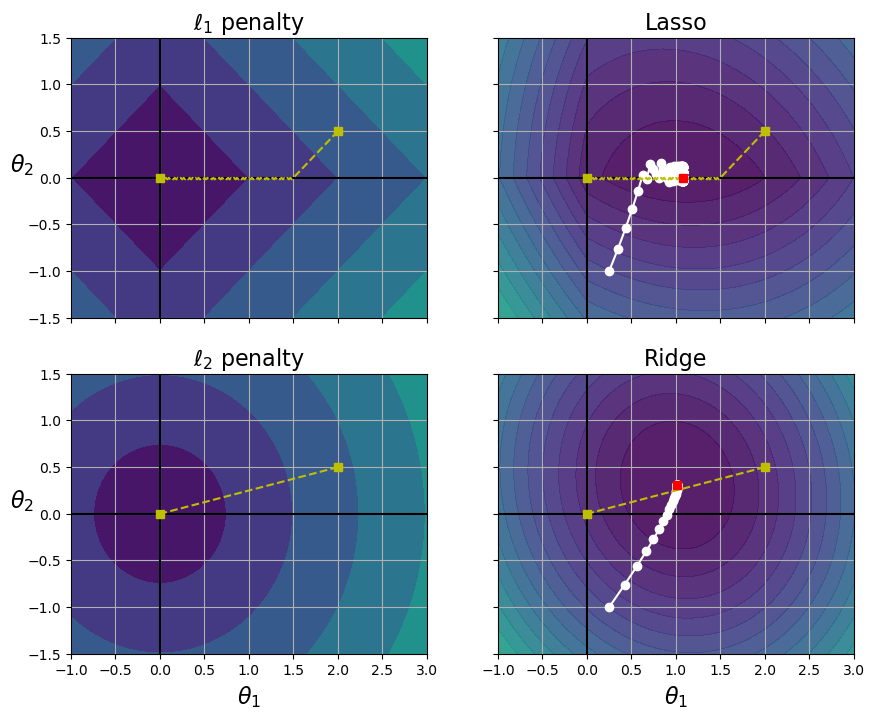

In [54]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)


# Logistic regression

Despite of its name Logistic regression is often used as a classifier used to estimate the probability of a given instance belonging to a class

(-10.0, 10.0, -0.1, 1.1)

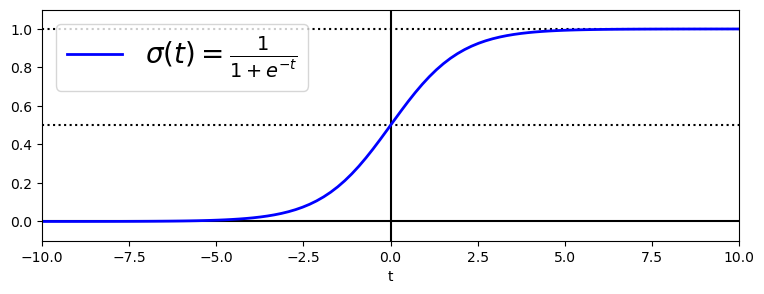

In [55]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])

The logistic regression was used in a previous notebook for the Iris Dataset

---

# Acknowledgments

This notebook is based on a variety of sources, usually other notebooks, the material was adapted to the topics covered during lessons. In some cases, the original notebooks were created for Python 2.x or older versions of Scikit-learn or Tensorflow and they have to be adapted to at least Python 3.7. 
 
We acknowledge the support of the National Science Foundation and the US Department of Energy under projects: DMREF-NSF 1434897, NSF OAC-1740111 and DOE DE-SC0016176 is recognized.

<div style="clear: both; display: table;">
<div style="border: none; float: left; width: 40%; padding: 10px">
<img src="fig/NSF.jpg" alt="National Science Foundation" style="width:50%" align="left">
    </div>
    <div style="border: none; float: right; width: 40%; padding: 10px">
<img src="fig/DOE.jpg" alt="National Science Foundation" style="width:50%" align="right">
</div>

---

# References

The snippets above are meant only to give a brief introduction to some of the most popular techniques in machine learning so you can decide whether this kind of analysis might be useful in your research. If it seems like machine learning will be important in your work, you may want to check out some of the resources listed below (arranged roughly from least to most technical):

This list is by no means an exhaustive list of books and resources. I am listing the books from which I took inspiration. Also, I am listing materials where I found better ways to present topics. Often I am amazed by how people can create approachable materials for seemingly dry subjects.

The order of the books goes from divulgation and practical to the more rigorous and mathematical. Slides, blogs, and videos are those I have found over the internet or suggested by others.

### Selection of Books on Machine Learning

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Hands-On Machine Learning  with Scikit-Learn and TensorFlow" 
       src="./fig/books/Hands-On Machine Learning  with Scikit-Learn and TensorFlow.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Hands-On Machine Learning  with Scikit-Learn and TensorFlow (First Edition [There is a second edition])<br>
      Auréleien Géron<br>
      2017<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Python Machine Learning - Raschka" 
       src="./fig/books/Python Machine Learning - Raschka.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Machine Learning, a Probabilistic Perspective<br>
      Sebastian Raschka and Vahid Mirjalili<br>
      2017<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Foundations of Machine Learning - Mohri" 
       src="./fig/books/Foundations of Machine Learning - Mohri.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Foundations of Machine Learning (Second Edition)<br>
      Mehryar Mohri, Afshin Rostamizadeh and Ameet Talwalkar<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Introduction to Machine Learning - Alpaydin" 
       src="./fig/books/Introduction to Machine Learning - Alpaydin.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Introduction to Machine Learning (Fourth Edition)<br>
      Ethem Alpaydin<br>
      2020<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Machine Learning, a Probabilistic Perspective - Murphy" 
       src="./fig/books/Machine Learning, a Probabilistic Perspective - Murphy.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Machine Learning, a Probabilistic Perspective<br>
      Kevin P. Murphy<br>
      2012<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Elements of Statistical Learning - Hastie" 
       src="./fig/books/Elements of Statistical Learning - Hastie.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      <a href="https://hastie.su.domains/Papers/ESLII.pdf">Elements of Statistical Learning</a><br>
      Trevor Hastie, Robert Tibshirani, and Jerome Friedman<br>
      2008<br>
  </div>
</div>


### Jupyter Notebooks

 * [Yale Digital Humanities Lab](https://github.com/YaleDHLab/lab-workshops)
 
 * Aurelien Geron Hands-on Machine Learning with Scikit-learn 
   [First Edition](https://github.com/ageron/handson-ml) and
   [Second Edition](https://github.com/ageron/handson-ml2)
   
 * [A progressive collection notebooks of the Machine Learning course by the University of Turin](https://github.com/rugantio/MachineLearningCourse)
   
 * [A curated set of jupyter notebooks about many topics](https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks)
   
### Videos

 * [Caltech's "Learning from Data" by Professor Yaser Abu-Mostafa](https://work.caltech.edu/telecourse.html)
 

 * [A Friendly Introduction to Machine Learning](https://www.youtube.com/watch?v=IpGxLWOIZy4)

In this 30-minute video, Luis Serrano (head of the machine learning at Udacity) offers intuitive, user-friendly introductions to the mechanics that drive several machine learning models, including Naive Bayes, Decision Tree, Logistic Regression, Neural Network, and Support Vector Machine classifiers. This video is a great place to start for those looking for quick intuitions about the ways these algorithms work.

 * [Hands-On Machine Learning with Scikit-Learn and TensorFlow (OREILLY)](http://shop.oreilly.com/product/0636920052289.do)

This OREILLY book offers a great high-level introduction to machine learning with Python. Aurélien Géron guides readers through ways one can use scikit-learn and other popular libraries to build machine learning models in Python. This is a great choice for those who just want to get work done, without necessarily unlocking the insights that would allow one to build models from scratch.

 * [Machine Learning Cheatsheets](https://becominghuman.ai/cheat-sheets-for-ai-neural-networks-machine-learning-deep-learning-big-data-678c51b4b463)

This collection of "cheat sheets" gives concise overviews of the API's and models behind many of the most prominent packages and concepts in machine learning and its allied fields, including different neural network architectures, numerical optimization techniques, algorithms appropriate for different tasks, scikit-learn, pandas, scikit-learn, scipy, ggpot2, dplyr and tidyr, big O notation, and several other topics. Recently identified as the "most popular" article on machine learning in Medium.

 * [Mining of Massive Datasets](http://www.mmds.org/)

This Stanford University course and digital publication offer introductions to a wide array of subtopics in machine learning. The authors focus on helping readers gain an intuitive understanding of how machine learning models work. One of the most lucid and concise treatments of machine learning available on the web.

 * [Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/)

This Stanford University course offers a spectacular introduction to Convolutional Neural Networks, the cornerstone of modern machine learning in the domain of computer vision. If your work involves images or video materials, and you'd like to apply machine learning techniques to your data, this course will help you get up and running with state-of-the-art techniques in convnets.

 * [Machine Learning (Andrew Ng, Coursera)](https://www.coursera.org/learn/machine-learning)

Andrew Ng's Coursera course on machine learning will help you master many of the fundamentals involved in modern machine learning. Professor Ng will guide you through a great deal of the math involved in contemporary machine learning, starting with simple linear classifiers and building up into complex neural network architectures. This class is ideal for those who like to understand the math behind the models they use.
 
 ---

# Back of the Book

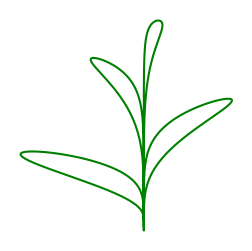

In [56]:
plt.figure(figsize=(3,3))
n = chapter_number
maxt=(2*(n-1)+3)*np.pi/2
t = np.linspace(np.pi/2, maxt, 1000)
tt= 1.0/(t+0.01)
x = (maxt-t)*np.cos(t)**3
y = t*np.sqrt(np.abs(np.cos(t))) + np.sin(0.3*t)*np.cos(2*t)
plt.plot(x, y, c="green")
plt.axis('off');

In [57]:
end = time.time()
print(f'Chapter {chapter_number} run in {int(end - start):d} seconds')

Chapter 4 run in 11 seconds
